In [1]:
# 1. Imports
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

In [2]:
# 2. Hypothetical Data (24 months)
np.random.seed(42)
months = pd.date_range(start="2023-01-01", periods=24, freq='MS')
base_sales = 1200 + np.cumsum(np.random.randint(-50, 70, size=24))
marketing_spend = 1000 + np.random.randint(-200, 300, size=24)
price = 10 + np.random.uniform(-1, 1, size=24)

df = pd.DataFrame({
    'ds': months,
    'y': base_sales,
    'marketing_spend': marketing_spend,
    'price': price
})

In [3]:
# 3. Holidays
holidays = pd.DataFrame({
    'holiday': 'promo_event',
    'ds': pd.to_datetime(['2023-01-01', '2023-11-01', '2024-01-01', '2024-11-01']),
    'lower_window': 0,
    'upper_window': 1,
})

In [4]:
# 4. Prophet Model
model = Prophet(holidays=holidays)
model.add_regressor('marketing_spend')
model.add_regressor('price')
model.fit(df)


15:38:02 - cmdstanpy - INFO - Chain [1] start processing
15:38:02 - cmdstanpy - INFO - Chain [1] done processing


In [5]:
# 5. Forecast Next 6 Months
future = model.make_future_dataframe(periods=6, freq='MS')
future['marketing_spend'] = np.append(marketing_spend, [1100, 1050, 1000, 950, 1100, 1200])
future['price'] = np.append(price, [10.2, 10.1, 9.8, 10.0, 10.3, 10.4])

forecast = model.predict(future)

In [6]:
# 6. ROP with Variable Lead Time
# Target next month
next_month = forecast.iloc[-6]  # first forecasted future month
avg_demand = next_month['yhat']
std_demand = (next_month['yhat_upper'] - next_month['yhat_lower']) / 4

# Lead time variability (in days)
avg_lead_time_days = 30
std_lead_time_days = 5

# Convert to months
avg_lt_months = avg_lead_time_days / 30
std_lt_months = std_lead_time_days / 30

# ROP Formula with uncertainty in demand & lead time
Z = 1.65  # 95% service level
safety_stock = Z * np.sqrt(
    (std_demand ** 2 * avg_lt_months) + 
    (std_lt_months ** 2 * avg_demand ** 2)
)
reorder_point = avg_demand * avg_lt_months + safety_stock

In [13]:
# 7. Output
print("\n📦 Reorder Point with Variable Lead Time:")
print(f"Avg Monthly Demand: {avg_demand:.2f}")
print(f"Std Demand: {std_demand:.2f}")
print(f"Avg Lead Time: {avg_lt_months:.2f} months")
print(f"Std Lead Time: {std_lt_months:.2f} months")
print(f"Safety Stock: {safety_stock:.2f}")
print(f"➡️ ROP: {reorder_point:.2f} units")
# Let's assume you're forecasting 6 months ahead and want to attach ROP to the first future month:
forecast.loc[forecast.index[-6], 'ROP'] = reorder_point  # Add ROP to that row



📦 Reorder Point with Variable Lead Time:
Avg Monthly Demand: 1587.17
Std Demand: 15.54
Avg Lead Time: 1.00 months
Std Lead Time: 0.17 months
Safety Stock: 437.22
➡️ ROP: 2024.39 units


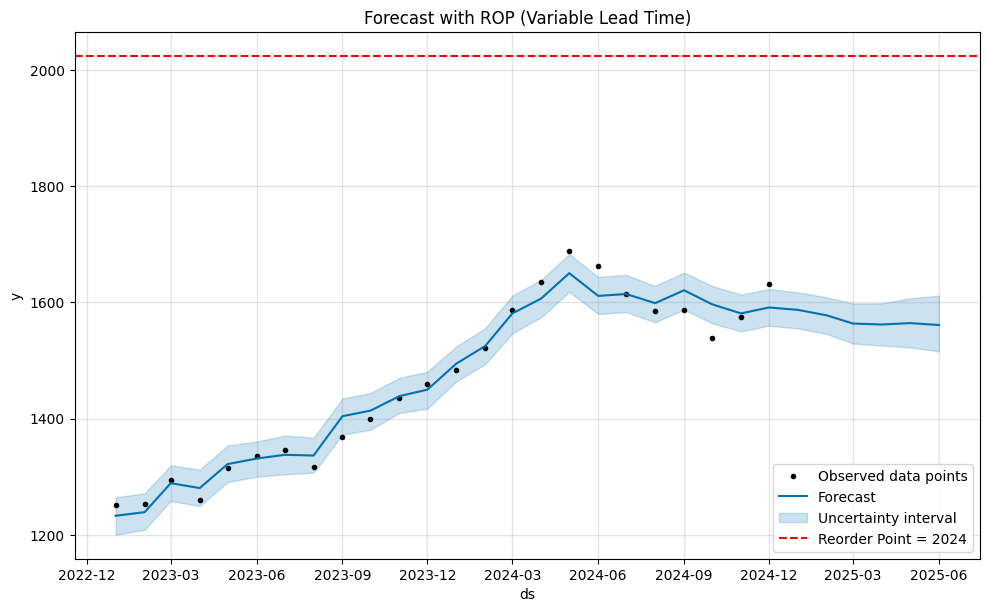

In [8]:
# 8. Plot with ROP
fig = model.plot(forecast)
plt.axhline(reorder_point, color='red', linestyle='--', label=f'Reorder Point = {reorder_point:.0f}')
plt.title("Forecast with ROP (Variable Lead Time)")
plt.legend()
plt.grid(True)
plt.show()